In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time
import seaborn as sb


In [2]:
dfi = pd.read_csv('./Data/Weather/london.csv')
dfi

,DATE,WND_DEG,WND_SPEED[m/s],VIS[m],TMP[C],DEW[C],AP[hPa],CIG[m]
0,2024-01-01 00:00:00,240.0,6.70,9999.0,9.0,5.0,995.0,914.0
1,2023-12-31 23:00:00,240.0,6.95,9999.0,9.0,5.0,994.5,1310.5
2,2023-12-31 22:00:00,240.0,7.95,9999.0,8.5,5.0,993.5,990.5
3,2023-12-31 21:00:00,240.0,7.70,9999.0,9.0,4.5,993.0,838.5
4,2023-12-31 20:00:00,240.0,6.70,9999.0,8.5,4.5,992.0,1295.5
...,...,...,...,...,...,...,...,...
235153,1988-01-29 17:00:00,270.0,6.45,8500.0,5.0,5.0,974.9,285.0
235154,1988-01-29 16:00:00,280.0,6.95,7000.0,5.0,5.0,973.9,1380.0
235155,1988-01-29 15:00:00,300.0,9.00,7500.0,5.0,5.0,972.9,405.0
235156,1988-01-29 14:00:00,300.0,5.90,7000.0,5.0,5.0,971.4,420.0


In [3]:
df = dfi.loc[dfi['DATE'] > '2023-07-01']
df

,DATE,WND_DEG,WND_SPEED[m/s],VIS[m],TMP[C],DEW[C],AP[hPa],CIG[m]
0,2024-01-01 00:00:00,240.0,6.70,9999.0,9.0,5.0,995.0,914.0
1,2023-12-31 23:00:00,240.0,6.95,9999.0,9.0,5.0,994.5,1310.5
2,2023-12-31 22:00:00,240.0,7.95,9999.0,8.5,5.0,993.5,990.5
3,2023-12-31 21:00:00,240.0,7.70,9999.0,9.0,4.5,993.0,838.5
4,2023-12-31 20:00:00,240.0,6.70,9999.0,8.5,4.5,992.0,1295.5
...,...,...,...,...,...,...,...,...
4382,2023-07-01 04:00:00,265.0,4.85,7499.5,17.5,16.0,1004.0,381.0
4383,2023-07-01 03:00:00,260.0,5.40,9999.0,18.0,15.5,1004.0,427.0
4384,2023-07-01 02:00:00,250.0,4.85,9999.0,18.0,16.0,1004.0,381.0
4385,2023-07-01 01:00:00,235.0,5.40,9999.0,19.0,16.0,1005.0,381.0


In [4]:
df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'
, 'TMP[C]': 'temp', 'DEW[C]': 'dew', 'AP[hPa]':'press','CIG[m]':'ceil'}, inplace=True)
df = df[['wind_sp','dew','press','temp']]
df = df.dropna()
df = df.reset_index(drop=True)
df

/tmp/ipykernel_15957/840753923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'


,wind_sp,dew,press,temp
0,6.70,5.0,995.0,9.0
1,6.95,5.0,994.5,9.0
2,7.95,5.0,993.5,8.5
3,7.70,4.5,993.0,9.0
4,6.70,4.5,992.0,8.5
...,...,...,...,...
4382,4.85,16.0,1004.0,17.5
4383,5.40,15.5,1004.0,18.0
4384,4.85,16.0,1004.0,18.0
4385,5.40,16.0,1005.0,19.0


In [5]:
df['nxt_target'] = df['temp'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4387 entries, 0 to 4386
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wind_sp     4387 non-null   float64
 1   dew         4387 non-null   float64
 2   press       4387 non-null   float64
 3   temp        4387 non-null   float64
 4   nxt_target  4387 non-null   float64
dtypes: float64(5)
memory usage: 171.5 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,wind_sp,dew,press,temp,nxt_target
0,6.70,5.0,995.0,9.0,9.0
1,6.95,5.0,994.5,9.0,8.5
2,7.95,5.0,993.5,8.5,9.0
3,7.70,4.5,993.0,9.0,8.5
4,6.70,4.5,992.0,8.5,9.0
...,...,...,...,...,...
3504,2.30,9.0,1019.0,17.0,17.0
3505,2.55,9.0,1019.0,17.0,19.0
3506,4.85,8.0,1018.0,19.0,19.0
3507,4.85,8.5,1018.0,19.0,19.0


In [8]:
train.iloc[:,-1:]

,nxt_target
0,9.0
1,8.5
2,9.0
3,8.5
4,9.0
...,...
3504,17.0
3505,19.0
3506,19.0
3507,19.0


In [9]:
train.iloc[:,:4]

,wind_sp,dew,press,temp
0,6.70,5.0,995.0,9.0
1,6.95,5.0,994.5,9.0
2,7.95,5.0,993.5,8.5
3,7.70,4.5,993.0,9.0
4,6.70,4.5,992.0,8.5
...,...,...,...,...
3504,2.30,9.0,1019.0,17.0
3505,2.55,9.0,1019.0,17.0
3506,4.85,8.0,1018.0,19.0
3507,4.85,8.5,1018.0,19.0


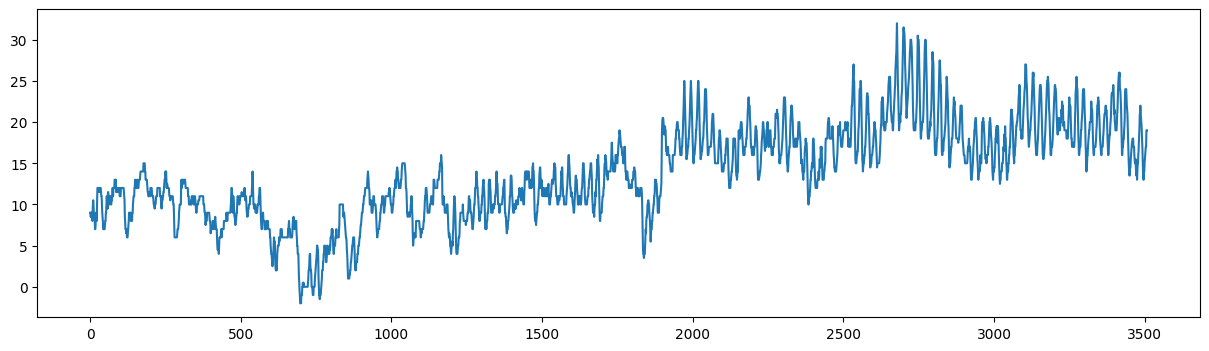

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["temp"])
plt.show()

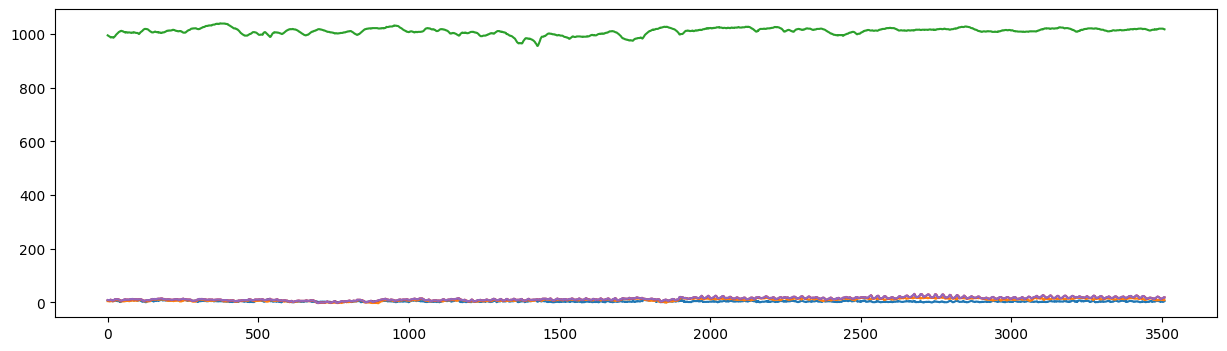

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3499, 10, 4])


tensor([ 1.2712, -1.0015, -1.2350, -0.8299])

In [17]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=4, hidden_units= 12, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [19]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:125.12289169733413
[2/5]  LossQ:41.70387096399645
[3/5]  LossQ:31.227919822445983
[4/5]  LossQ:30.261301288621326
[5/5]  LossQ:33.0614066238777


In [20]:
np.savetxt('./SavedModels/Weather/London/loss/qlstm.txt',histQ)

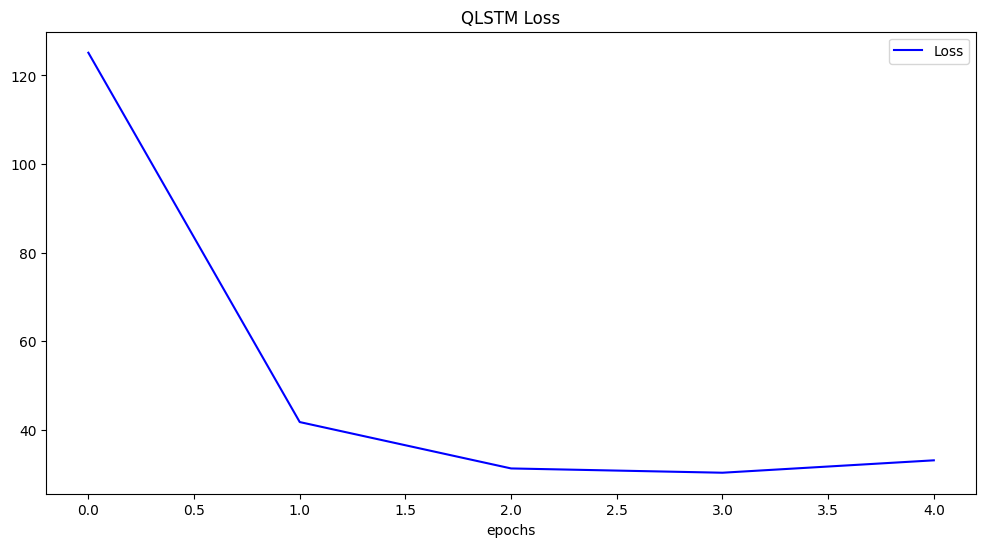

In [21]:
#np.savetxt('./SavedModels/Loss/qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [22]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [23]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([0.1837, 0.2767, 0.2153,  ..., 0.6597, 1.1388, 0.9834],
       grad_fn=<ViewBackward0>)


In [24]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [25]:
pred_y_train

tensor([[0.1837],
        [0.2767],
        [0.2153],
        ...,
        [0.6597],
        [1.1388],
        [0.9834]], grad_fn=<ViewBackward0>)

In [26]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [27]:
np.savetxt('./SavedModels/Weather/London/y_train_true.txt',y_train_true)
np.savetxt('./SavedModels/Weather/London/y_test_true.txt',y_test_true)
np.savetxt('./SavedModels/Weather/London/train/qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/London/test/qlstm.txt',y_test_pred)

Training dataset RMSE:4.181166705903256


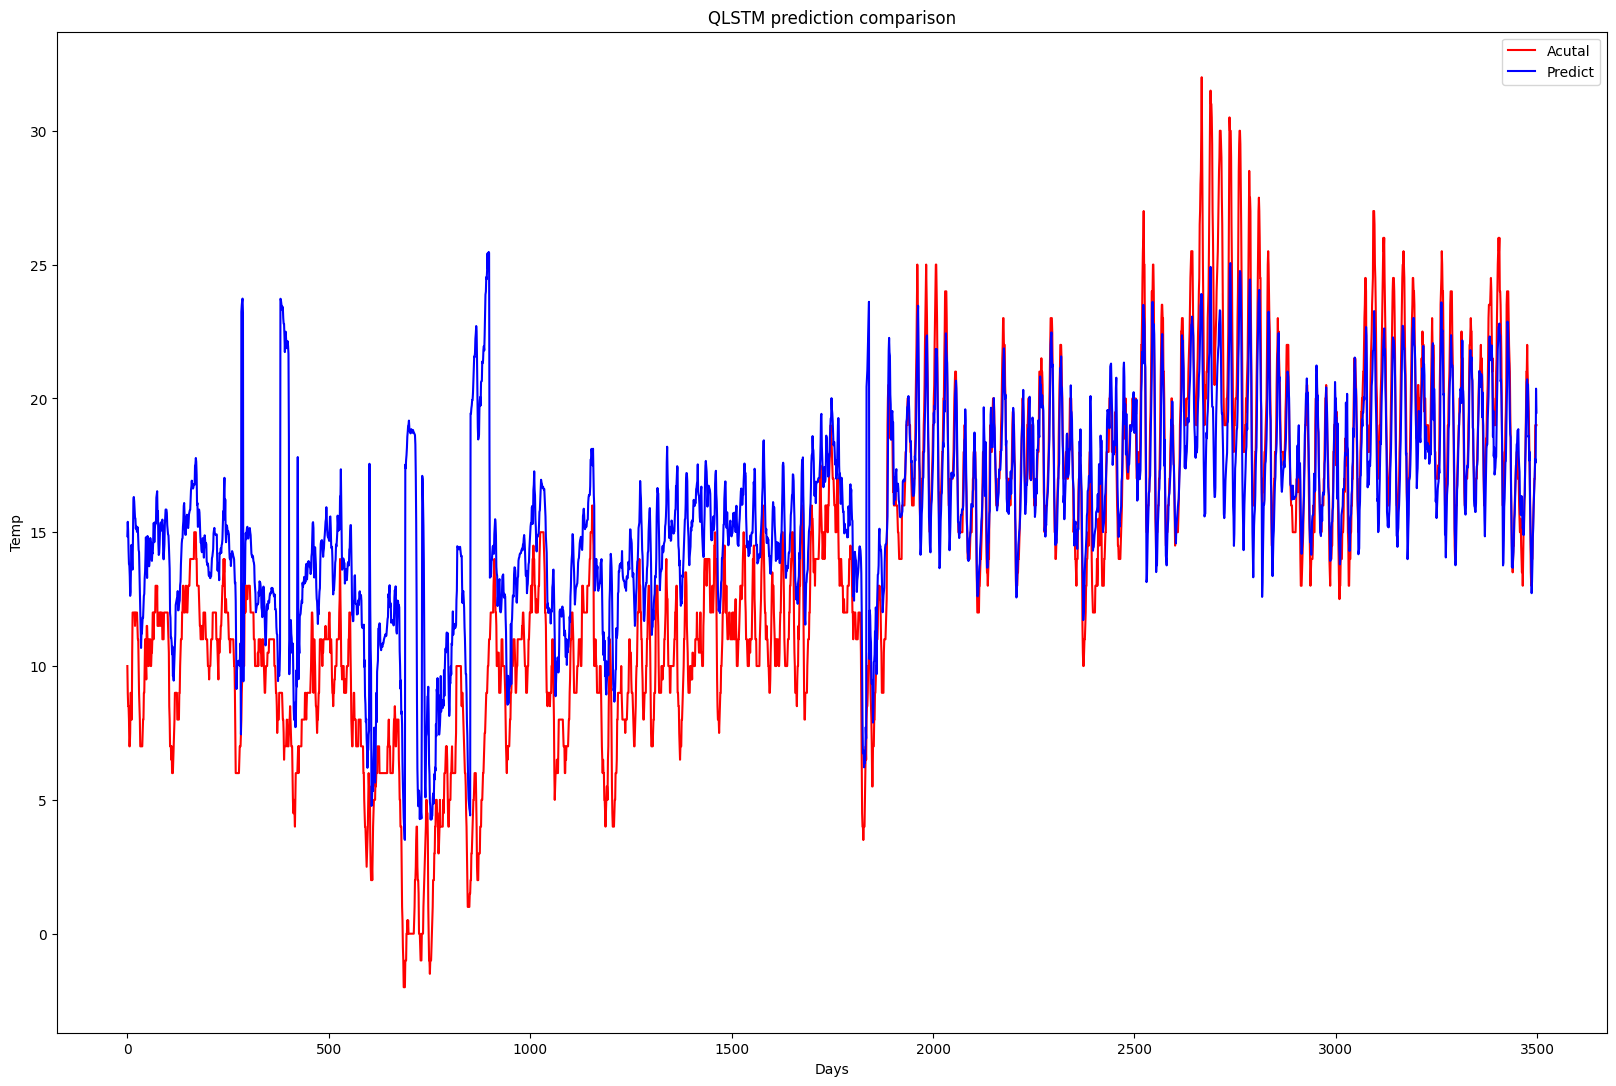

In [28]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Temp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:1.5671469730899583


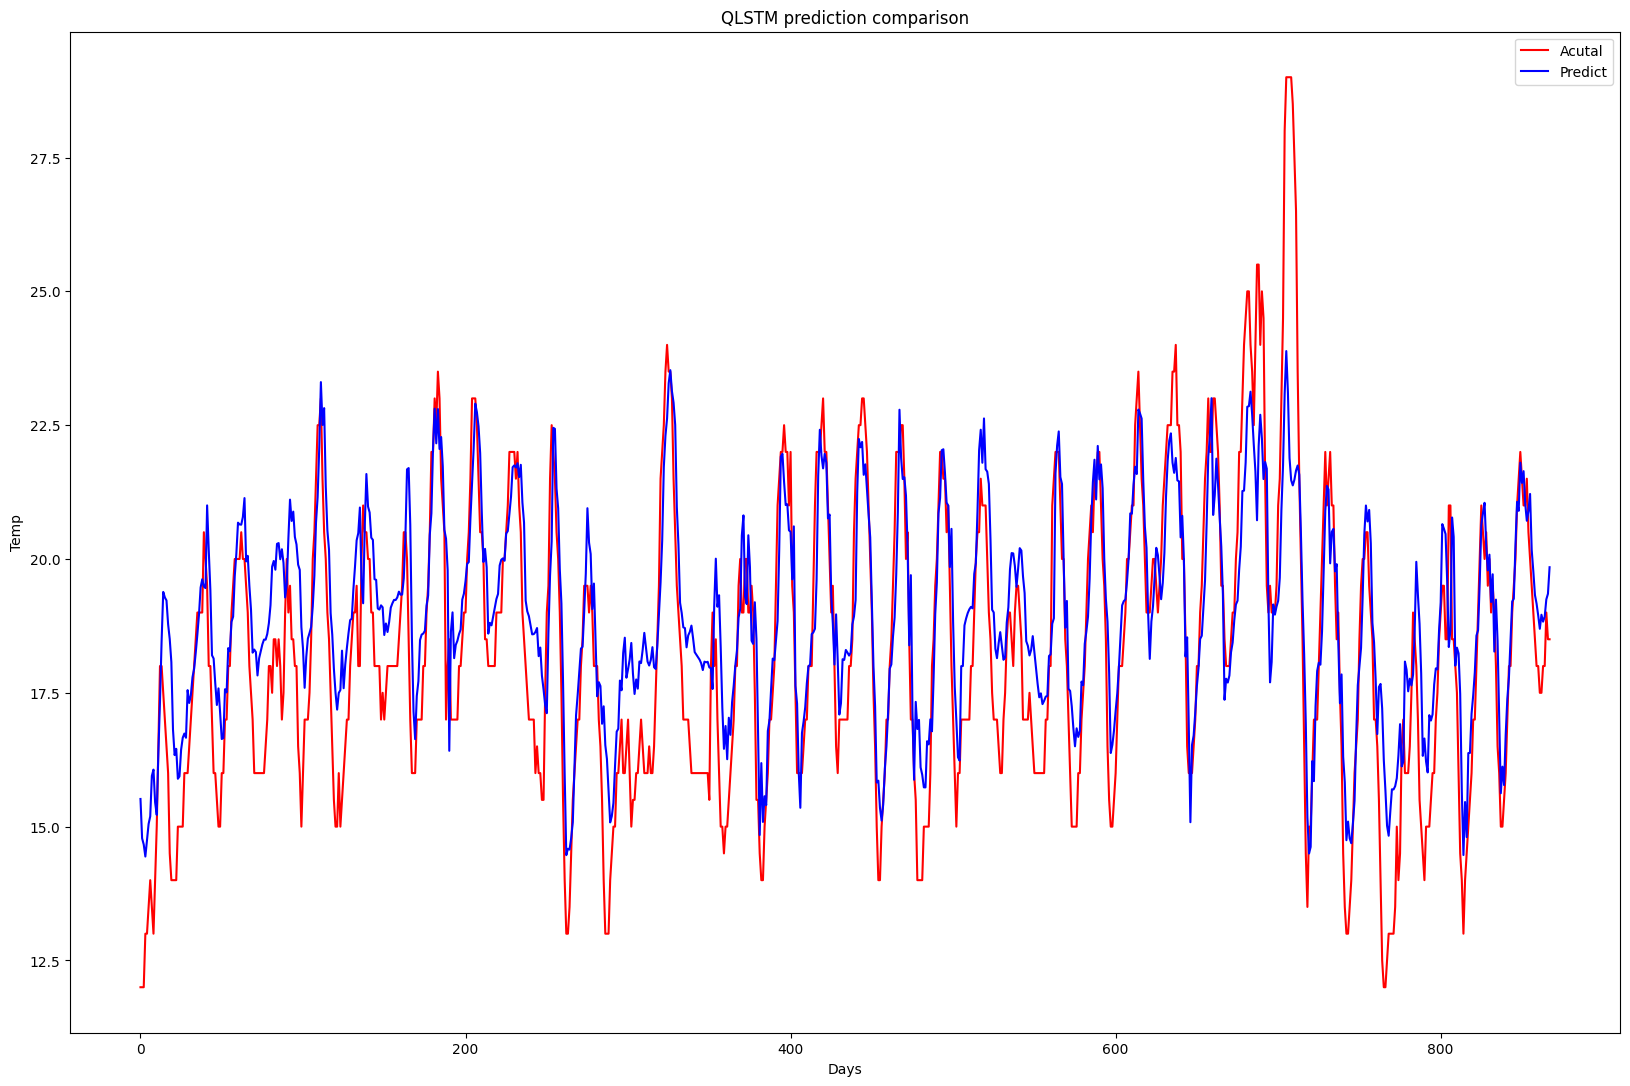

In [29]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Temp')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [30]:
torch.save(modelQ.state_dict(),'./SavedModels/Weather/London/model/QLSTM_aqi_sd')